# Validació generalització model amb **Leave-One-Grup-Out**

Es repeteix l'ajust de machine learning però amb un bucle on cada vegada es deixa fora de l'entrenament un dels laboratoris, els subjectes del laboratori que es queda fora es fa server per validar el model, l'objectiu és comprobar com de bé generalitza el model

## **PAS1: importar llibreries**

In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 9.4 MB/s eta 0:00:00


In [ ]:
# importar llibreries
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score


import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os


## **PAS2: enllaçar amb drive**

In [ ]:
#paths relatius a l'arxiu ipynb
from google.colab import drive
import glob
# recuperar ruta de l0scritp
script_name = '6_CatBoost_OneOut.ipynb'
drive.mount(os.getcwd() + '/drive')
script_path = glob.glob(os.getcwd() + '/**/' + script_name, recursive = True)
print(script_path)
head_tail = os.path.split(script_path[0])
# guardem carpeta de treball
work_path = head_tail[0];


Mounted at /content/drive
['/content/drive/MyDrive/TFM/Finals/6_CatBoost_OneOut.ipynb']


## **PAS3: llegir arxius**

In [ ]:
#llegir CSV
v_path = work_path + '/CSV/harmonized_data.csv'
# Lectura arxiu
vol = pd.read_csv(v_path, encoding='latin-1')

In [ ]:
print("El conjunt de dades conté informació de " + str(vol.shape[0]) + " persones diferents i " + str(vol.shape[1]) + " variables.")

El conjunt de dades conté informació de 316 persones diferents i 39 variables.


In [ ]:
# no sé si afegir el "total intracranial" del dataset vol_ICV
vol.head()

,Unnamed: 0,left cerebral white matter,left cerebral cortex,left lateral ventricle,left inferior lateral ventricle,left cerebellum white matter,left cerebellum cortex,left thalamus,left caudate,left putamen,...,right hippocampus,right amygdala,right accumbens area,right ventral DC,SITE,SUB_ID,DX_GROUP,AGE_AT_SCAN,SEX,FIQ
0,0,0.148201,0.172916,0.004299,0.000391,0.008866,0.029530,0.004925,0.003081,0.004373,...,0.002594,0.001163,0.000535,0.002639,ABIDEII-BNI_1,29028,TEA,21.0,1,94.0
1,1,0.143959,0.177085,0.004137,0.000384,0.009878,0.034666,0.005442,0.002604,0.004202,...,0.003006,0.001243,0.000511,0.002759,ABIDEII-BNI_1,29029,TEA,20.0,1,97.0
2,2,0.135129,0.166210,0.005572,0.000428,0.011263,0.037202,0.004642,0.003030,0.003988,...,0.002713,0.001262,0.000484,0.002822,ABIDEII-BNI_1,29030,TEA,18.0,1,111.0
3,3,0.149008,0.166349,0.006931,0.000424,0.012182,0.037870,0.005128,0.002787,0.003658,...,0.002787,0.001200,0.000442,0.002929,ABIDEII-BNI_1,29031,TEA,21.0,1,97.0
4,4,0.142604,0.162814,0.009000,0.000391,0.010841,0.032813,0.004516,0.002994,0.003793,...,0.003066,0.001127,0.000441,0.002720,ABIDEII-BNI_1,29037,TEA,19.0,1,139.0


Agafar les dades dels individus de 10 a 30 anys


In [ ]:
# el rang amb millor rendiment és aquell amb els subjectes compresos en el rang d'edats de 10 a 32 anys
vol = vol[vol['AGE_AT_SCAN'].between(10, 32)].copy().reset_index(drop=True)

In [ ]:
print("El conjunt de dades conté informació de " + str(vol.shape[0]) + " persones diferents i " + str(vol.shape[1]) + " variables.")

El conjunt de dades conté informació de 294 persones diferents i 39 variables.


## PAS4: Preparació Dades

Eliminar columnes unnamed, SITE, SUB_ID i FIQ

In [ ]:
# data frame
vol.drop(vol.columns[vol.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
# eliminar paràmetres
vol.drop(['SUB_ID','FIQ'], axis=1, inplace=True)
vol.columns

Index(['left cerebral white matter', 'left cerebral cortex',
       'left lateral ventricle', 'left inferior lateral ventricle',
       'left cerebellum white matter', 'left cerebellum cortex',
       'left thalamus', 'left caudate', 'left putamen', 'left pallidum',
       '3rd ventricle', '4th ventricle', 'brain-stem', 'left hippocampus',
       'left amygdala', 'csf', 'left accumbens area', 'left ventral DC',
       'right cerebral white matter', 'right cerebral cortex',
       'right lateral ventricle', 'right inferior lateral ventricle',
       'right cerebellum white matter', 'right cerebellum cortex',
       'right thalamus', 'right caudate', 'right putamen', 'right pallidum',
       'right hippocampus', 'right amygdala', 'right accumbens area',
       'right ventral DC', 'SITE', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX'],
      dtype='object')

## PAS5: Leave-One-Group-Out Cross-Validation

Funció per ajust hiper paràmetres

In [ ]:
import optuna

# Funció objectiu per Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 6,10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 1.0),
        "loss_function": "Logloss",
        "eval_metric": "Accuracy",
        "verbose": False,
    }

    model = CatBoostClassifier(**params)
    model.fit(xtrain, ytrain, eval_set=(xtest, ytest), early_stopping_rounds=50)

    preds = model.predict(xtest)
    acc = accuracy_score(ytest, preds)
    return acc


Laboratoris:

In [ ]:
labs = vol['SITE'].unique()

Bucle de processat

In [ ]:
prediccions = []
# deixar fora un laboratori cada vegada
for lab in labs:
    SITE_OUT = lab
    # organitzar dades
    df_to_test = vol[vol['SITE'] != SITE_OUT].copy(True).reset_index(drop=True)
    df_SITE_OUT = vol[vol['SITE'] == SITE_OUT].copy(True).reset_index(drop=True)
    # eliminar informació del site
    df_to_test.drop(['SITE'], axis=1, inplace=True)
    df_SITE_OUT.drop(['SITE'], axis=1, inplace=True)

    print (df_to_test.shape)
    print (df_SITE_OUT.shape)

    x = df_to_test.drop(['DX_GROUP'], axis=1)
    y = df_to_test['DX_GROUP'].astype('category')

    x_SITE_OUT = df_SITE_OUT.drop(['DX_GROUP'], axis=1)
    y_SITE_OUT = df_SITE_OUT['DX_GROUP'].astype('category')

    # escalat de les dades
    scaler = StandardScaler().set_output(transform="pandas")
    x_scaled = scaler.fit_transform(x)
    x_SITE_OUT_scaled = scaler.fit_transform(x_SITE_OUT)

    # assignar dades d'entrenament i dades de test (el lab que queda fora és el de test)
    xtrain = x_scaled
    ytrain = y
    xtest = x_SITE_OUT_scaled
    ytest = y_SITE_OUT

    # convertir categories a números (TEA a 0 i CONTROL a 1)
    ytrain_np = ytrain.map({"TEA": 0, "CONTROL": 1}).to_numpy()
    ytest_np = ytest.map({"TEA": 0, "CONTROL": 1}).to_numpy()

    # Estudi amb Optuna
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=30)

    # Inicialització del model amb millors hiperparàmetres
    cat_model_Best = CatBoostClassifier(
        iterations=study.best_params['iterations'],
        depth=study.best_params['depth'],
        learning_rate=study.best_params['learning_rate'],
        l2_leaf_reg=study.best_params['l2_leaf_reg'],
        border_count=study.best_params['border_count'],
        random_strength=study.best_params['random_strength'],
        bagging_temperature=study.best_params['bagging_temperature'],
        subsample=study.best_params['subsample'],
        colsample_bylevel=study.best_params['colsample_bylevel'],
        loss_function='Logloss',
        eval_metric='Accuracy',
        verbose=False
    )

    # Entrenament
    cat_model_Best.fit(xtrain, ytrain, eval_set=(xtest, ytest))

    # Prediccions
    y_pred_CAT_Best = cat_model_Best.predict(xtest)
    prediccions.append(y_pred_CAT_Best)

[I 2025-12-31 12:01:56,075] A new study created in memory with name: no-name-532377b5-6498-438d-a672-61392ec40b21


(271, 35)
(23, 35)


[I 2025-12-31 12:01:58,515] Trial 0 finished with value: 0.5652173913043478 and parameters: {'iterations': 236, 'depth': 10, 'learning_rate': 0.2366602102355779, 'l2_leaf_reg': 5.9112385562787555, 'border_count': 144, 'random_strength': 2.0016006296756794, 'bagging_temperature': 0.3129120486810385, 'subsample': 0.7640825120155675, 'colsample_bylevel': 0.9308219786242544}. Best is trial 0 with value: 0.5652173913043478.
[I 2025-12-31 12:02:01,932] Trial 1 finished with value: 0.6086956521739131 and parameters: {'iterations': 772, 'depth': 9, 'learning_rate': 0.1791163627703259, 'l2_leaf_reg': 4.916605474596878, 'border_count': 200, 'random_strength': 2.9685136133925996, 'bagging_temperature': 0.17956443931615063, 'subsample': 0.7118724477667757, 'colsample_bylevel': 0.909433575380945}. Best is trial 1 with value: 0.6086956521739131.
[I 2025-12-31 12:02:02,450] Trial 2 finished with value: 0.6956521739130435 and parameters: {'iterations': 819, 'depth': 6, 'learning_rate': 0.1953839123537

(259, 35)
(35, 35)


[I 2025-12-31 12:02:35,590] Trial 0 finished with value: 0.4857142857142857 and parameters: {'iterations': 436, 'depth': 10, 'learning_rate': 0.18158338352621295, 'l2_leaf_reg': 8.80516507228631, 'border_count': 84, 'random_strength': 0.58522387478064, 'bagging_temperature': 0.47693968607614623, 'subsample': 0.9516353495172776, 'colsample_bylevel': 0.6880205318504709}. Best is trial 0 with value: 0.4857142857142857.
[I 2025-12-31 12:02:35,841] Trial 1 finished with value: 0.5714285714285714 and parameters: {'iterations': 656, 'depth': 6, 'learning_rate': 0.26177124081339015, 'l2_leaf_reg': 5.523161305384515, 'border_count': 134, 'random_strength': 2.891310352305756, 'bagging_temperature': 0.36116532728620554, 'subsample': 0.7281823234431606, 'colsample_bylevel': 0.6777294044395401}. Best is trial 1 with value: 0.5714285714285714.
[I 2025-12-31 12:02:36,511] Trial 2 finished with value: 0.5714285714285714 and parameters: {'iterations': 712, 'depth': 6, 'learning_rate': 0.272696972111901

(262, 35)
(32, 35)


[I 2025-12-31 12:03:29,675] Trial 0 finished with value: 0.6875 and parameters: {'iterations': 947, 'depth': 9, 'learning_rate': 0.10041397480308947, 'l2_leaf_reg': 9.993037785355108, 'border_count': 132, 'random_strength': 3.6402746698098833, 'bagging_temperature': 0.1893119494868849, 'subsample': 0.9321415616191039, 'colsample_bylevel': 0.5145597559916797}. Best is trial 0 with value: 0.6875.
[I 2025-12-31 12:03:29,904] Trial 1 finished with value: 0.5625 and parameters: {'iterations': 451, 'depth': 7, 'learning_rate': 0.16443477166142836, 'l2_leaf_reg': 9.279854606190916, 'border_count': 45, 'random_strength': 7.315865120802257, 'bagging_temperature': 0.1521588161609495, 'subsample': 0.7974311525848943, 'colsample_bylevel': 0.8910647763378563}. Best is trial 0 with value: 0.6875.
[I 2025-12-31 12:03:31,107] Trial 2 finished with value: 0.65625 and parameters: {'iterations': 724, 'depth': 8, 'learning_rate': 0.04499491890664875, 'l2_leaf_reg': 8.584346116511856, 'border_count': 233, 

(269, 35)
(25, 35)


[I 2025-12-31 12:04:32,704] Trial 0 finished with value: 0.36 and parameters: {'iterations': 853, 'depth': 7, 'learning_rate': 0.08180215937624556, 'l2_leaf_reg': 7.264359258566094, 'border_count': 140, 'random_strength': 3.5714834314021098, 'bagging_temperature': 0.25095586611058907, 'subsample': 0.8667959953945961, 'colsample_bylevel': 0.7696971365666054}. Best is trial 0 with value: 0.36.
[I 2025-12-31 12:04:35,919] Trial 1 finished with value: 0.4 and parameters: {'iterations': 437, 'depth': 10, 'learning_rate': 0.26906086513254107, 'l2_leaf_reg': 2.715709250317508, 'border_count': 171, 'random_strength': 6.181700689134874, 'bagging_temperature': 0.39316595388287445, 'subsample': 0.9158378662979716, 'colsample_bylevel': 0.5011517727823729}. Best is trial 1 with value: 0.4.
[I 2025-12-31 12:04:38,433] Trial 2 finished with value: 0.28 and parameters: {'iterations': 849, 'depth': 8, 'learning_rate': 0.15805598315845265, 'l2_leaf_reg': 8.420715434281247, 'border_count': 220, 'random_s

(235, 35)
(59, 35)


[I 2025-12-31 12:05:23,390] Trial 0 finished with value: 0.5932203389830508 and parameters: {'iterations': 319, 'depth': 8, 'learning_rate': 0.0898117792419063, 'l2_leaf_reg': 5.806871677888789, 'border_count': 180, 'random_strength': 4.286468308839182, 'bagging_temperature': 0.8597260595070211, 'subsample': 0.8843155970317939, 'colsample_bylevel': 0.6469538272171997}. Best is trial 0 with value: 0.5932203389830508.
[I 2025-12-31 12:05:24,417] Trial 1 finished with value: 0.5932203389830508 and parameters: {'iterations': 730, 'depth': 9, 'learning_rate': 0.08780311749509151, 'l2_leaf_reg': 5.5293803627189, 'border_count': 98, 'random_strength': 2.5098571612612197, 'bagging_temperature': 0.05017031400324101, 'subsample': 0.6028762354958015, 'colsample_bylevel': 0.8328827983026608}. Best is trial 0 with value: 0.5932203389830508.
[I 2025-12-31 12:05:25,899] Trial 2 finished with value: 0.6271186440677966 and parameters: {'iterations': 607, 'depth': 7, 'learning_rate': 0.10377291494580469

(248, 35)
(46, 35)


[I 2025-12-31 12:06:13,794] Trial 0 finished with value: 0.5869565217391305 and parameters: {'iterations': 934, 'depth': 7, 'learning_rate': 0.12013905533181812, 'l2_leaf_reg': 5.359538487652472, 'border_count': 76, 'random_strength': 2.500606208603139, 'bagging_temperature': 0.5619282508974723, 'subsample': 0.8920343082960116, 'colsample_bylevel': 0.6008730704887795}. Best is trial 0 with value: 0.5869565217391305.
[I 2025-12-31 12:06:14,881] Trial 1 finished with value: 0.6304347826086957 and parameters: {'iterations': 784, 'depth': 6, 'learning_rate': 0.1851443239772286, 'l2_leaf_reg': 8.77145903250683, 'border_count': 237, 'random_strength': 8.404209390670106, 'bagging_temperature': 0.6231952205127225, 'subsample': 0.7985243314230543, 'colsample_bylevel': 0.979271577425675}. Best is trial 1 with value: 0.6304347826086957.
[I 2025-12-31 12:06:15,362] Trial 2 finished with value: 0.5 and parameters: {'iterations': 830, 'depth': 8, 'learning_rate': 0.25956517302793775, 'l2_leaf_reg': 

(252, 35)
(42, 35)


[I 2025-12-31 12:06:48,924] Trial 0 finished with value: 0.6904761904761905 and parameters: {'iterations': 647, 'depth': 9, 'learning_rate': 0.1487795222480581, 'l2_leaf_reg': 6.350493133081968, 'border_count': 165, 'random_strength': 8.019084453847652, 'bagging_temperature': 0.5802858587632478, 'subsample': 0.656560871616885, 'colsample_bylevel': 0.9930527122812514}. Best is trial 0 with value: 0.6904761904761905.
[I 2025-12-31 12:06:50,104] Trial 1 finished with value: 0.6666666666666666 and parameters: {'iterations': 251, 'depth': 10, 'learning_rate': 0.223186209890177, 'l2_leaf_reg': 4.2019142699298975, 'border_count': 100, 'random_strength': 0.8031484156146026, 'bagging_temperature': 0.0660912615771938, 'subsample': 0.7452775173728873, 'colsample_bylevel': 0.6700257250562174}. Best is trial 0 with value: 0.6904761904761905.
[I 2025-12-31 12:06:50,555] Trial 2 finished with value: 0.6666666666666666 and parameters: {'iterations': 852, 'depth': 7, 'learning_rate': 0.0233641634475154

(262, 35)
(32, 35)


[I 2025-12-31 12:07:24,155] Trial 0 finished with value: 0.59375 and parameters: {'iterations': 707, 'depth': 7, 'learning_rate': 0.2909765009240571, 'l2_leaf_reg': 9.402917536586271, 'border_count': 76, 'random_strength': 1.0669297989353892, 'bagging_temperature': 0.1698288607364551, 'subsample': 0.9218703744854941, 'colsample_bylevel': 0.8768694446570817}. Best is trial 0 with value: 0.59375.
[I 2025-12-31 12:07:26,478] Trial 1 finished with value: 0.6875 and parameters: {'iterations': 629, 'depth': 10, 'learning_rate': 0.11406212532705542, 'l2_leaf_reg': 4.73350988572535, 'border_count': 185, 'random_strength': 9.38675087742791, 'bagging_temperature': 0.8289528384184262, 'subsample': 0.8197355518099041, 'colsample_bylevel': 0.7187627611365337}. Best is trial 1 with value: 0.6875.
[I 2025-12-31 12:07:26,757] Trial 2 finished with value: 0.59375 and parameters: {'iterations': 546, 'depth': 6, 'learning_rate': 0.21389151412824753, 'l2_leaf_reg': 8.76647006805807, 'border_count': 96, 'r

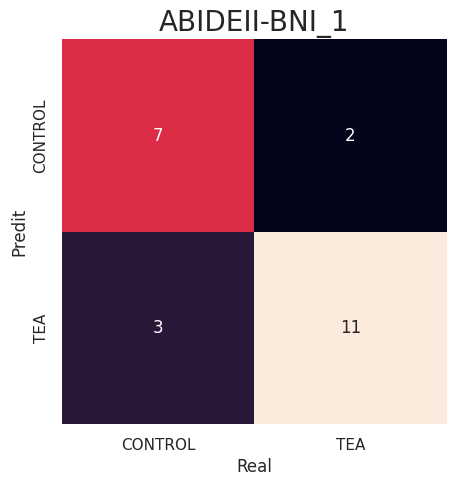

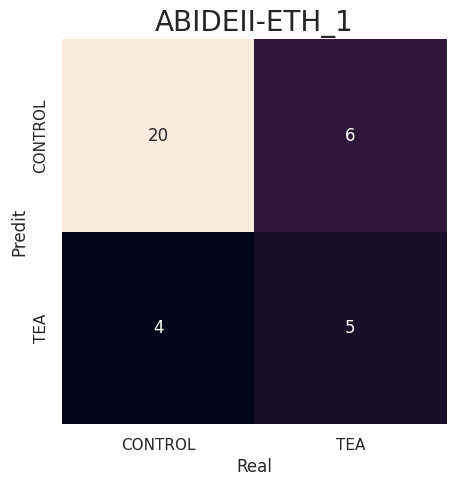

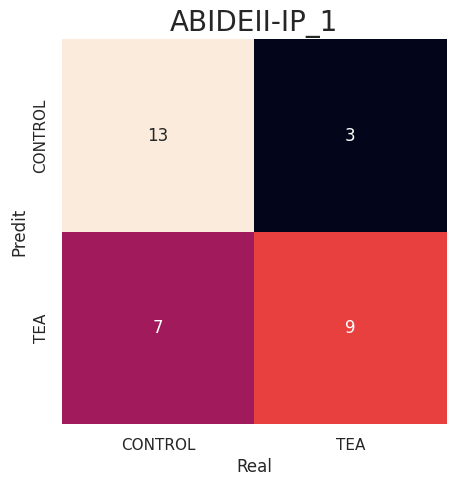

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


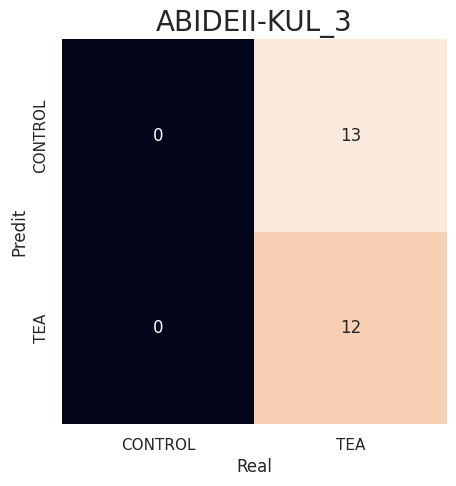

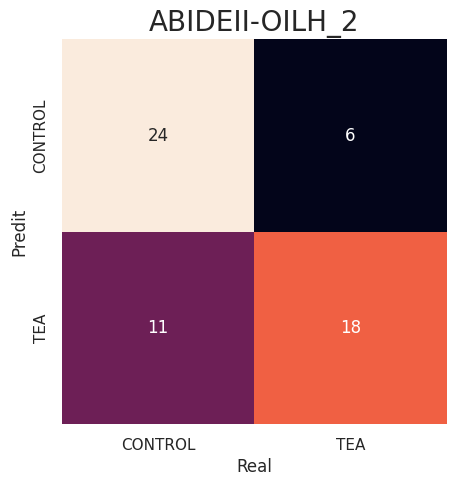

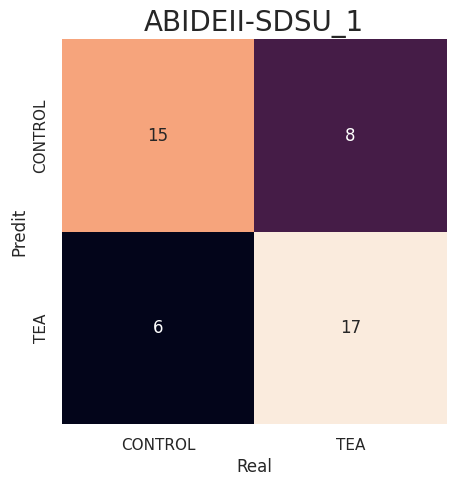

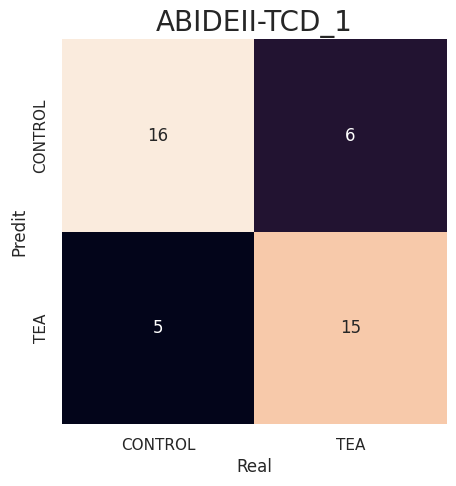

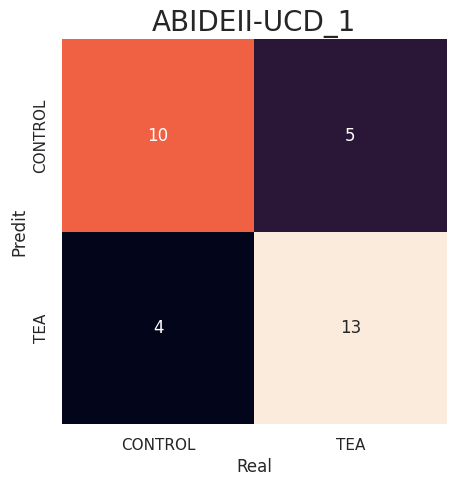

,Lab Out,Precisió,f1 TEA,f1 Control,Precisió avg,Precisió weighted
0,ABIDEII-BNI_1,0.782609,0.814815,0.736842,0.775828,0.780914
1,ABIDEII-ETH_1,0.714286,0.500000,0.800000,0.650000,0.705714
2,ABIDEII-IP_1,0.687500,0.642857,0.722222,0.682540,0.692460
3,ABIDEII-KUL_3,0.480000,0.648649,0.000000,0.324324,0.648649
4,ABIDEII-OILH_2,0.711864,0.679245,0.738462,0.708853,0.714374
5,ABIDEII-SDSU_1,0.695652,0.708333,0.681818,0.695076,0.696229
6,ABIDEII-TCD_1,0.738095,0.731707,0.744186,0.737947,0.737947
7,ABIDEII-UCD_1,0.718750,0.742857,0.689655,0.716256,0.719581


In [ ]:
macro_avg_f1 = []
macro_weighted_f1 = []

accuracy = []
TEA = []
CONTROL = []


i = 0
for p in prediccions:
    SITE_OUT = labs[i]
    df_SITE_OUT = vol[vol['SITE'] == SITE_OUT].copy(True).reset_index(drop=True)
    ytest = df_SITE_OUT['DX_GROUP'].astype('category')

    # Generate classification report
    class_report = classification_report(ytest, p, output_dict=True)
    TEA.append(class_report['TEA']['f1-score'])
    CONTROL.append(class_report['CONTROL']['f1-score'])

    # Append to list
    macro_avg_f1.append(class_report['macro avg']['f1-score'] )
    macro_weighted_f1.append(class_report['weighted avg']['f1-score'] )

    accuracy.append(class_report['accuracy'])

    # Plot Confusion Matrix
    mat = confusion_matrix(p, ytest)
    names = np.unique(p)
    plt.figure(figsize=(5, 5))
    plt.title(SITE_OUT,fontsize=20)
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=names, yticklabels=names)
    plt.xlabel('Real')
    plt.ylabel('Predit')
    plt.show()

    i += 1

metriques = {'Lab Out':labs, 'Precisió':accuracy, 'f1 TEA':TEA,
             'f1 Control':CONTROL,
             'Precisió avg':macro_avg_f1,
             'Precisió weighted':macro_weighted_f1}

df_metriques = pd.DataFrame(metriques)

#taula resum
display(df_metriques)